In [1]:
import requests
from bs4 import BeautifulSoup
import re

In [2]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) '
                         'Chrome/89.0.4389.90 Safari/537.36 Edg/89.0.774.63'}

# 获取视频名称和作者
url = 'https://www.bilibili.com/video/BV1T4411w7aU?from=search&seid=2192040820971667824&spm_id_from=333.337.0.0'
response = requests.get(url, headers)
response.encoding = 'utf-8'
page_text = response.text
soup = BeautifulSoup(page_text, 'lxml')
video_title = soup.find('span', class_='tit tr-fix').text
print('视频名称：' + video_title)
uploader = soup.find('a', attrs={'report-id': 'name'}).text.strip()
print('UP主：' + uploader)

视频名称：【赵本山】Bad Guy
UP主：烩烩


#获取cid的方法：在视频网址上找到BV后面的一串字符复制，并放到“https://api.bilibili.com/x/player/pagelist?bvid=BV”和“&jsonp=jsonp”之间 

例如：https://api.bilibili.com/x/player/pagelist?bvid=BV15341177PE&jsonp=jsonp

31621681获取cid（31621681）之后，输入 https://api.bilibili.com/x/v1/dm/list.so?oid=31621681
获得改革春风吹满地的弹幕列表

## 爬取弹幕

In [3]:
# 获取弹幕文件
cid = '101446157'
xml = 'https://api.bilibili.com/x/v1/dm/list.so?oid={}'.format(cid)
response = requests.get(xml, headers)
response.encoding = 'utf-8'
xml_text = response.text
soup = BeautifulSoup(xml_text, 'lxml')
barrages = [re.sub(r'\s+', '', bar.text) for bar in soup.find_all('d')]

# 查看弹幕数量
print('弹幕数量：' + str(len(barrages)))

# 将弹幕写入文件
with open('./barrages2.txt', 'w', encoding='utf-8') as output_file:
    for bar in barrages:
        output_file.write(bar + '\n')
print('弹幕信息已成功写入文件！')

弹幕数量：242
弹幕信息已成功写入文件！


## 爬取评论

In [4]:
import math
import json
from openpyxl import Workbook
import time

url='https://api.bilibili.com/x/v2/reply?jsonp=jsonp&type=1&oid=766398101&sort=2&pn='

#获取json数据
def download(url):
    result=requests.get(url)
    return json.loads(result.text)["data"]

#excel数据导出
def excel_out(data):
    global  index
    ws.cell(row=index,column=1,value=index-1)
    ws.cell(row=index,column=2,value=data["member"]["uname"])
    ws.cell(row=index,column=3,value=data["member"]["level_info"]["current_level"])
    ws.cell(row=index,column=4,value=data["member"]["sex"])
    ws.cell(row=index,column=5,value=data["content"]["message"])
    ws.cell(row=index,column=6,value=data["like"])
    ws.cell(row=index,column=7,value=time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(data['ctime'])))
    index+=1
    
index=2;
wb=Workbook()
ws=wb.active
ws.title="视频传播大数据分析"
ws.cell(row=1,column=1,value="序号")
ws.cell(row=1,column=2,value="用户名")
ws.cell(row=1,column=3,value="等级")
ws.cell(row=1,column=4,value="性别")
ws.cell(row=1,column=5,value="评论")
ws.cell(row=1,column=6,value="点赞数")
ws.cell(row=1,column=7,value="评论时间")

data=download(url+"1")
totalPage=math.ceil(data["page"]["count"]/data["page"]["size"])
print("total: %s页" % totalPage)
for i in range(1,totalPage+1):
    data=download(url+str(i))
    replies=data["replies"]
    for v in replies:
        excel_out(v)
    print("当前进度 %.2f%%" % (i/totalPage*100))
    time.sleep(1)
wb.save("D:/计算传播学/testxx.xlsx")
print("完成\（*.*）/")

total: 1页
当前进度 100.00%
完成\（*.*）/


## 修改日期的格式

In [2]:
#data0 原始数据
#data1 将日期格式修改为%Y-%m

In [18]:
import pandas as pd
from datetime import datetime

data0 = pd.read_excel(r"赵本山念诗之王鬼畜评论.xlsx")
data0.head()

,序号,用户名,等级,性别,评论,点赞数,评论时间
0,1,煜轩殿下,6,男,先做个大胆的假设，这个视频十年后还会被顶上来[小电视_赞],112946,2019-01-02 12:01:20
1,2,Yamiヤミ闇,6,保密,这首歌毁了多少人的四级听力,136285,2018-12-16 13:22:09
2,3,嗑糖少女OOO,6,保密,以前谁上春晚谁火，现在谁火谁上春晚,364547,2018-02-12 14:09:48
3,4,盒子想吃肉,6,女,其实笑完真的心里有点酸酸的，以前家族人多，除夕的时候，年夜饭吃的早，收拾晚了刚好春晚开始，那...,329371,2018-12-28 23:02:39
4,5,花痴簡花痴,5,男,今天去洗澡，洗着洗着就唱起了改革吹风春满地。。。澡堂子一群人看着我，更可怕的是有人还来了句中...,61373,2018-12-16 14:15:38


In [19]:
#修改评论时间的格式

timenot=data0["评论时间"]
timenot = timenot.map(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")) #也可写成timenot = pd.to_datetime(timenot)
timeyes=timenot.dt.strftime("%Y-%m")
data0["评论时间"]=timeyes
data1=data0
data1.head()

,序号,用户名,等级,性别,评论,点赞数,评论时间
0,1,煜轩殿下,6,男,先做个大胆的假设，这个视频十年后还会被顶上来[小电视_赞],112946,2019-01
1,2,Yamiヤミ闇,6,保密,这首歌毁了多少人的四级听力,136285,2018-12
2,3,嗑糖少女OOO,6,保密,以前谁上春晚谁火，现在谁火谁上春晚,364547,2018-02
3,4,盒子想吃肉,6,女,其实笑完真的心里有点酸酸的，以前家族人多，除夕的时候，年夜饭吃的早，收拾晚了刚好春晚开始，那...,329371,2018-12
4,5,花痴簡花痴,5,男,今天去洗澡，洗着洗着就唱起了改革吹风春满地。。。澡堂子一群人看着我，更可怕的是有人还来了句中...,61373,2018-12


## 计算不同时间段评论的数量

In [5]:
#切记！写筛选条件时，日期都要写作两位数
datatime=data1["评论时间"]
data1[(datatime < "2019-01") & (datatime >="2018-12")]

,序号,用户名,等级,性别,评论,点赞数,评论时间
1,2,Yamiヤミ闇,6,保密,这首歌毁了多少人的四级听力,136285,2018-12
3,4,盒子想吃肉,6,女,其实笑完真的心里有点酸酸的，以前家族人多，除夕的时候，年夜饭吃的早，收拾晚了刚好春晚开始，那...,329371,2018-12
4,5,花痴簡花痴,5,男,今天去洗澡，洗着洗着就唱起了改革吹风春满地。。。澡堂子一群人看着我，更可怕的是有人还来了句中...,61373,2018-12
5,6,请问今天你脱单了吗,5,保密,第一遍：什么东西？？？\n第二遍：有点意思…\n第三遍：改革春风吹满地…吹满地！,193119,2018-12
6,7,六道僵尸,5,男,晚上做梦梦到鬼了，结果鬼突然唱起来改革春风吹满地……，把我笑醒了,354645,2018-12
...,...,...,...,...,...,...,...
23654,23655,赵旻晟,5,男,都600万了？我前几天看还500多万,1,2018-12
23655,23656,带带大仙贝,5,保密,b站的其他up主也做了一些利用这个音频的作品，请问他们得到授权了吗？b站用户是不是也盗音频了？,1,2018-12
23708,23709,玄幻の逐风者,5,保密,明明就是抖音先出的，这边非要说原创也是醉了，我好久之前就在抖音上看到用这首歌了！！！,4,2018-12
23762,23763,しまむー,6,女,抖音音乐差评,1,2018-12


In [6]:
#切记！写筛选条件时，日期都要写作两位数

data1[(datatime < "2019-01") & (datatime >="2018-12")]["评论时间"].value_counts()

2018-12    361
Name: 评论时间, dtype: int64

In [7]:
# 按月统计评论的个数

data1["count"] = 1
df_result = data1.groupby("评论时间")["count"].agg(["count"])
df_result

,count
评论时间,
2018-02,115
2018-03,21
2018-04,7
2018-05,2
2018-06,3
2018-07,2
2018-08,4
2018-09,1
2018-10,1


https://blog.csdn.net/WANG_hl/article/details/105224231

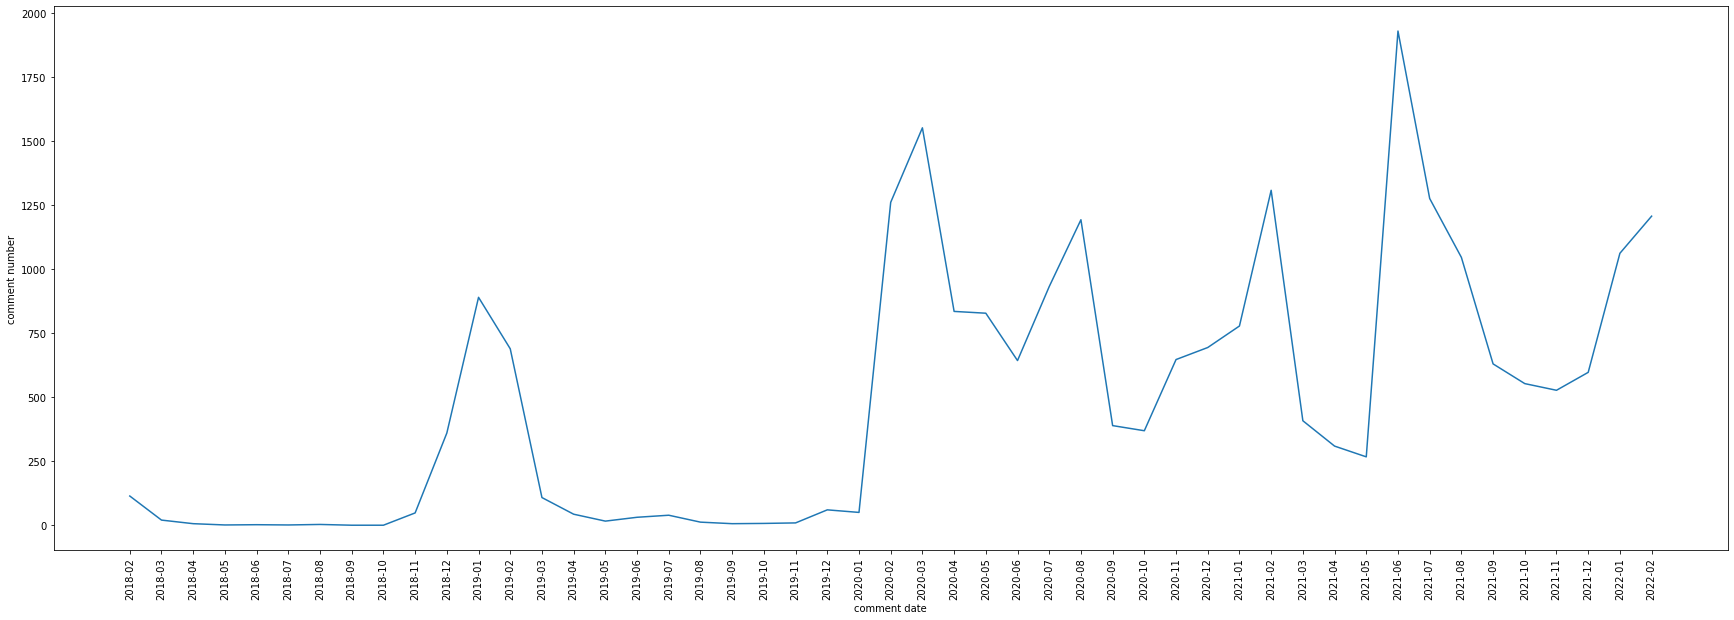

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(30,10))  # 定义图的大小
plt.xlabel("comment date")     # X轴标签
plt.ylabel("comment number")        # Y轴坐标标签
plt.xticks(rotation=90) #45为旋转的角度
plt.plot(df_result) # 绘制曲线图
plt.show()

## 计算评论的字数

In [12]:
wordlongth=[]

for comment in data1["评论"]:
    a=len(comment)
    wordlongth.append(a)
data1["评论长度"]=wordlongth
data1

,序号,用户名,等级,性别,评论,点赞数,评论时间,count,评论长度
0,1,煜轩殿下,6,男,先做个大胆的假设，这个视频十年后还会被顶上来[小电视_赞],112946,2019-01,1,29
1,2,Yamiヤミ闇,6,保密,这首歌毁了多少人的四级听力,136285,2018-12,1,13
2,3,嗑糖少女OOO,6,保密,以前谁上春晚谁火，现在谁火谁上春晚,364547,2018-02,1,17
3,4,盒子想吃肉,6,女,其实笑完真的心里有点酸酸的，以前家族人多，除夕的时候，年夜饭吃的早，收拾晚了刚好春晚开始，那...,329371,2018-12,1,352
4,5,花痴簡花痴,5,男,今天去洗澡，洗着洗着就唱起了改革吹风春满地。。。澡堂子一群人看着我，更可怕的是有人还来了句中...,61373,2018-12,1,63
...,...,...,...,...,...,...,...,...,...
23800,23801,有点头怵,5,男,抄袭抖嘤？ 已举报,1,2018-12,1,10
23801,23802,bili_28112096217,4,保密,就这？这么多播放？,1,2020-08,1,9
23802,23803,火箭少女101是我的,5,男,低俗封面，举报！,1,2020-01,1,8
23803,23804,丶夜袭尼姑庵灬,3,男,一天一遍一天一遍一天一遍一天一遍一天一遍一天一遍一天一遍一天一遍一天一遍一天一遍,1,2021-12,1,40


## 评论点赞数和评论时间的关系

In [13]:
#单因素方差分析

import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
 
formula = '点赞数~ 评论时间'
anova_results = anova_lm(ols(formula,data1).fit())
anova_results

,df,sum_sq,mean_sq,F,PR(>F)
评论时间,48.0,5.840466e+09,1.216764e+08,6.4811,6.837344e-40
Residual,23756.0,4.459959e+11,1.877403e+07,NaN,NaN


In [14]:
#事后多重比较

from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(data1['点赞数'],data1['评论时间'])
tukey_result = mc.tukeyhsd(alpha = 0.5)
print(tukey_result)

      Multiple Comparison of Means - Tukey HSD, FWER=0.50      
 group1  group2  meandiff  p-adj     lower      upper    reject
---------------------------------------------------------------
2018-02 2018-03 -3620.1014  0.213  -6843.5048  -396.6981   True
2018-02 2018-04 -3639.5776    0.9  -8927.5081  1648.3529  False
2018-02 2018-05 -3635.9348    0.9 -13323.9046   6052.035  False
2018-02 2018-06 -3646.7681    0.9 -11590.6947  4297.1584  False
2018-02 2018-07 -3627.4348    0.9 -13315.4046   6060.535  False
2018-02 2018-08 -3609.9348    0.9 -10518.6665  3298.7969  False
2018-02 2018-09 -3628.4348    0.9 -17270.6168 10013.7472  False
2018-02 2018-10 -3639.4348    0.9 -17281.6168 10002.7472  False
2018-02 2018-11 -3635.5164  0.001  -5952.7976 -1318.2353   True
2018-02 2018-12   -178.022    0.9  -1632.4919  1276.4478  False
2018-02 2019-01  -3319.125  0.001  -4665.0318 -1973.2182   True
2018-02 2019-02 -3639.3754  0.001  -5007.5081 -2271.2426   True
2018-02 2019-03 -3636.1963  0.001  -5451

## 点赞数量与评论字数长度的关系

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [16]:
#将评论长度和点赞数两个series单独组成一个dataframe
longthgood = pd.DataFrame({ '评论长度' :data1["评论长度"], '点赞数' :data1["点赞数"]})
longthgood

,评论长度,点赞数
0,29,112946
1,13,136285
2,17,364547
3,352,329371
4,63,61373
...,...,...
23800,10,1
23801,9,1
23802,8,1
23803,40,1


In [17]:
#先测量相关性
#结果相关系数极低，而且根本不显著，无法做回归分析

x=longthgood["评论长度"]
y=longthgood['点赞数']

import scipy.stats as ss
result3 = ss.pearsonr(x, y)
result3

(0.011760384789119524, 0.06960665446243917)

In [18]:
#这里做回归分析只是为了试一下,不相关前提下做回归无意义
#R-squared根本就是0.000

import statsmodels.api as sm

X = sm.add_constant(x)#添加常数项
model = sm.OLS(y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    点赞数   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.293
Date:                Sat, 19 Feb 2022   Prob (F-statistic):             0.0696
Time:                        00:11:28   Log-Likelihood:            -2.3325e+05
No. Observations:               23805   AIC:                         4.665e+05
Df Residuals:                   23803   BIC:                         4.665e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.8215     29.492      2.435      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## 评论字数长度与评论时间的关系

In [19]:
#将评论长度和评论时间两个series单独组成一个dataframe
longthtime = pd.DataFrame({ '评论长度' :data1["评论长度"], '评论时间' :data1["评论时间"]})
longthtime

,评论长度,评论时间
0,29,2019-01
1,13,2018-12
2,17,2018-02
3,352,2018-12
4,63,2018-12
...,...,...
23800,10,2018-12
23801,9,2020-08
23802,8,2020-01
23803,40,2021-12


In [20]:
#单因素方差分析

import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
 
formula = '评论长度~ 评论时间'
anova_results = anova_lm(ols(formula,data1).fit())
anova_results

,df,sum_sq,mean_sq,F,PR(>F)
评论时间,48.0,7.736636e+07,1.611799e+06,146.475706,0.0
Residual,23756.0,2.614078e+08,1.100387e+04,NaN,NaN


In [21]:
#事后多重比较

from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(data1['评论长度'],data1['评论时间'])
tukey_result = mc.tukeyhsd(alpha = 0.5)
print(tukey_result)

    Multiple Comparison of Means - Tukey HSD, FWER=0.50     
 group1  group2  meandiff p-adj    lower      upper   reject
------------------------------------------------------------
2018-02 2018-03  194.8882  0.001   116.8498  272.9266   True
2018-02 2018-04  -58.8261    0.9  -186.8466   69.1944  False
2018-02 2018-05  655.1739  0.001   420.6287  889.7192   True
2018-02 2018-06  -45.1594    0.9  -237.4815  147.1626  False
2018-02 2018-07  -22.3261    0.9  -256.8713  212.2192  False
2018-02 2018-08    9.1739    0.9  -158.0861   176.434  False
2018-02 2018-09  536.1739  0.001   205.8974  866.4504   True
2018-02 2018-10   41.1739    0.9  -289.1026  371.4504  False
2018-02 2018-11   -7.5404    0.9   -63.6416   48.5609  False
2018-02 2018-12   42.1434 0.1092     6.9308   77.3561   True
2018-02 2019-01   175.817  0.001   143.2327  208.4013   True
2018-02 2019-02  102.9406  0.001    69.8182   136.063   True
2018-02 2019-03  101.5592  0.001    57.5991  145.5194   True
2018-02 2019-04   24.719

## 评论点赞数和等级的关系

In [22]:
#单因素方差分析

import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
 
formula = '点赞数~ 等级'
anova_results = anova_lm(ols(formula,data1).fit())
anova_results

,df,sum_sq,mean_sq,F,PR(>F)
等级,1.0,1.658607e+08,1.658607e+08,8.740844,0.003115
Residual,23803.0,4.516705e+11,1.897536e+07,NaN,NaN


In [23]:
#事后多重比较

from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(data1['点赞数'],data1['等级'])
tukey_result = mc.tukeyhsd(alpha = 0.5)
print(tukey_result)

  Multiple Comparison of Means - Tukey HSD, FWER=0.50   
group1 group2 meandiff p-adj    lower     upper   reject
--------------------------------------------------------
     0      2  -3.0203    0.9 -800.1869  794.1462  False
     0      3  -2.2515    0.9 -755.7153  751.2124  False
     0      4   3.0258    0.9 -732.7453  738.7969  False
     0      5  62.3098    0.9 -669.5059  794.1255  False
     0      6 412.7298    0.9 -330.5614 1156.0209  False
     2      3   0.7689    0.9 -374.5549  376.0927  False
     2      4   6.0461    0.9 -332.3609  344.4532  False
     2      5  65.3301    0.9 -264.3886  395.0488  False
     2      6 415.7501 0.3145   61.2901  770.2101   True
     3      4   5.2773    0.9 -210.9461  221.5006  False
     3      5  64.5612    0.9  -137.794  266.9165  False
     3      6 414.9812  0.031  174.4087  655.5537   True
     4      5   59.284    0.9  -61.5424  180.1104  False
     4      6  409.704  0.001  232.1469   587.261   True
     5      6   350.42 0.0019  

可见，6级号的点赞数和其他等级的点赞数存在显著差别，6级号的特征，6级号的舆论建构、引导作用

## 用户画像

In [12]:
#性别分布

a=0
b=0
c=0
genders=data1['性别']
for gender in genders:
    if gender == '男':
        a+=1
    if gender == '女':
        b+=1
    elif gender == '保密':
        c+=1
print(a,b,c)

8454 3921 11430


In [25]:
#等级分布

d=0
e=0
f=0
g=0
h=0
i=0
j=0
grades=data1['等级']
for grade in grades:
    if grade == 0:
        d+=1
    if grade == 1:
        e+=1 
    if grade == 2:
        f+=1 
    if grade == 3:
        g+=1
    if grade == 4:
        h+=1
    if grade == 5:
        i+=1
    elif grade == 6:
        j+=1
print(d,e,f,g,h,i,j)

109 0 555 1584 5675 13167 2715


In [ ]:
#点赞分布






**加一部分对于B站用户群体的介绍**

## 文本清洗

In [26]:
comment0=data1["评论"]

In [27]:
#清除特殊符号

import re
pattern = r"[!\"#$%&'()*+,-./:;<=>?@[\\\]^_^{|}~—！，。？、￥…（）：【】《》‘’“”\s]+"
re_obj = re.compile(pattern)

def clear(text):
    return re_obj.sub("",text)

comment1= comment0.apply(clear)

In [28]:
#分词

import jieba

# 生成分词
comment2 = comment1.apply(lambda x : list(jieba.cut(x)))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\12297\AppData\Local\Temp\jieba.cache
Loading model cost 0.479 seconds.
Prefix dict has been built successfully.


In [51]:
#停用词处理

def get_stopword():
    s = set()
    with open(r"呆萌的停用词表.txt",encoding = 'UTF-8') as f:
        for line in f:
            s.add(line.strip())
    return s

def remove_stopword(words):
    return [word for word in words if word not in stopword]

stopword = get_stopword()
comment = comment2.apply(remove_stopword)

## 词频统计

In [52]:
from itertools import chain
from collections import Counter

li_2d = comment.tolist()
#将二维列表转换为一维
li_1d = list(chain.from_iterable(li_2d))
print(f'总词汇量：{len(li_1d)}')
c = Counter(li_1d)
print(f'不重复词汇量：{len(c)}')
common = c.most_common(100)
print(common)

总词汇量：184538
不重复词汇量：17013
[('版', 10634), ('吹', 1779), ('满地', 1558), ('春风', 1484), ('考古', 1345), ('播放', 1271), ('改革', 1194), ('打卡', 1105), ('弹幕', 1057), ('世界', 848), ('鬼畜', 822), ('一亿', 789), ('一遍', 730), ('春晚', 716), ('万', 656), ('助攻', 655), ('争气', 648), ('笑', 627), ('B', 603), ('新年快乐', 565), ('老师', 540), ('之宝', 529), ('火辣辣', 526), ('加油', 510), ('哭', 508), ('听', 506), ('赵本山', 501), ('哥版', 500), ('宝岛', 499), ('火', 484), ('请', 484), ('刷', 482), ('念诗', 474), ('亿', 466), ('之王', 451), ('镇站', 445), ('真的', 430), ('小品', 429), ('b', 422), ('中国', 403), ('手机', 396), ('call', 386), ('亿遍', 384), ('ω', 380), ('妖', 374), ('妙', 374), ('增加', 347), ('原版', 346), ('填词', 345), ('再来', 332), ('时间', 329), ('av19390801', 328), ('德隆', 324), ('记得', 321), ('知识', 320), ('ﾟ', 315), ('时代', 314), ('名字', 311), ('️', 310), ('日语', 308), ('经典', 306), ('猫和老鼠', 302), ('风景', 299), ('影版', 290), ('家', 289), ('震动', 284), ('柯南版', 282), ('回来', 280), ('唢呐', 279), ('计算器', 278), ('笛子', 276), ('av37883690', 276), ('二胡', 275), ('古筝', 

In [53]:
# 将所有的分词合并
words = []

for content in comment:
    words.extend(content)

In [56]:
from pyecharts.charts import WordCloud
from pyecharts.globals import SymbolType
from pyecharts import options as opts
from pyecharts.globals import ThemeType, CurrentConfig

# 创建分词数据框
corpus = pd.DataFrame(words, columns=['word'])
corpus['cnt'] = 1

# 分组统计
g = corpus.groupby(['word']).agg({'cnt': 'count'}).sort_values('cnt', ascending=False)

g.head(50)

#生成词云图
wordhigh3 = WordCloud(init_opts=opts.InitOpts(width='1350px', height='750px', theme=ThemeType.MACARONS))
wordhigh3.add('common', data_pair=common,
          word_size_range=[15, 108], textstyle_opts=opts.TextStyleOpts(font_family='cursive'),
          shape=SymbolType.DIAMOND)
wordhigh3.set_global_opts(title_opts=opts.TitleOpts('word2018'),
                         toolbox_opts=opts.ToolboxOpts(is_show=True, orient='vertical'),
                         tooltip_opts=opts.TooltipOpts(is_show=True, background_color='red', border_color='yellow'))
wordhigh3.render("总词云.html")

'C:\\Users\\12297\\python学习\\python数据分析\\总词云.html'